# Correlated Assets and Portfolio Risks

## Introduction

This project studies how correlation between risky assets influences the risk of a simple two-asset portfolio. The aim is to build a minimal but mathematically clean simulation that illustrates the role of correlation in diversification.

We model two assets by a two-dimensional geometric Brownian motion with correlation parameter $\rho \in [-1,1]$. By varying $\rho$ and simulating joint paths, we can observe how the distribution of a fixed-weight portfolio changes.

The goals of the project are:

- define the two-asset Black-Scholes dynamics with correlated Brownian drivers  
- construct correlated Gaussian increments efficiently  
- simulate joint price paths for a range of correlation values  
- compute empirical means and variances of portfolio log-returns at maturity  
- compare the simulated portfolio variance to the analytical expression  
- generate visual output that shows the effect of $\rho$ on diversification.


### Mathematical setup

We consider two risky assets with price processes $(S_t^{(1)})_{t \ge 0}$ and $(S_t^{(2)})_{t \ge 0}$.

Each asset follows a geometric Brownian motion:
$$
dS_t^{(i)} = \mu_i S_t^{(i)}\, dt + \sigma_i S_t^{(i)}\, dW_t^{(i)}, \qquad i=1,2,
$$
where
- $\mu_i$ are real constants,
- $\sigma_i > 0$ are volatilities,
- $(W_t^{(1)}, W_t^{(2)})$ is a two dimensional Brownian motion.

The Brownian drivers satisfy
$$
\operatorname{corr}(dW_t^{(1)}, dW_t^{(2)}) = \rho,
\qquad \rho \in [-1,1].
$$

The parameter $\rho$ controls the dependence structure. When $\rho = 1$ the shocks are identical. When $\rho = -1$ the shocks move in opposite directions. When $\rho = 0$ the increments are independent.

We study the terminal distribution of a static portfolio with weights $w_1$ and $w_2$:
$$
V_T = w_1 S_T^{(1)} + w_2 S_T^{(2)}.
$$

Our objective is to understand how the variance of $V_T$ changes as $\rho$ varies, both analytically and through simulation.


## Simulation plan

We discretise the time interval $[0,T]$ into $N_{\text{steps}}$ steps of size $\Delta t = T / N_{\text{steps}}$ and simulate the geometric Brownian motions using their exact GBM update in log form.

At each time step we need correlated Gaussian increments $(\Delta W_t^{(1)}, \Delta W_t^{(2)})$ with
$$
\mathbb{E}[\Delta W_t^{(i)}] = 0, \qquad
\operatorname{Var}(\Delta W_t^{(i)}) = \Delta t, \qquad
\operatorname{Corr}(\Delta W_t^{(1)}, \Delta W_t^{(2)}) = \rho.
$$

We construct these by:

1. sampling independent standard normals $Z_1, Z_2 \sim N(0,1)$,
2. applying a linear transformation that imposes the required correlation via a Cholesky factor of the covariance matrix
   $$
   \Sigma = 
   \begin{pmatrix}
   1 & \rho \\
   \rho & 1
   \end{pmatrix}.
   $$

Given correlated increments, the asset updates are
$$
S_{t+\Delta t}^{(i)} = S_t^{(i)} \exp\left((\mu_i - \tfrac{1}{2}\sigma_i^2)\Delta t + \sigma_i \Delta W_t^{(i)}\right), \qquad i=1,2.
$$

For each choice of $\rho$ in a grid inside $[-1,1]$ we will:

- simulate $N_{\text{paths}}$ joint paths $(S_t^{(1)}, S_t^{(2)})$ up to time $T$,
- compute the portfolio returns
  $$
  R_p = w_1 \log\left(\frac{S_T^{(1)}}{S_0^{(1)}}\right)
      + w_2 \log\left(\frac{S_T^{(2)}}{S_0^{(2)}}\right),
  $$
- estimate $\operatorname{Var}(R_p)$ empirically from the simulated sample,
- compare the empirical variance with the analytical value
  $$
  \operatorname{Var}(R_p)
  = w_1^2 \sigma_1^2 T
  + w_2^2 \sigma_2^2 T
  + 2 w_1 w_2 \rho \sigma_1 \sigma_2 T.
  $$

This gives a numerical illustration of how portfolio risk depends on the correlation parameter $\rho$.


#### Parameters and Libraries

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# model parameters
S0_1 = 100
S0_2 = 100

mu1 = 0.05
mu2 = 0.04

sigma1 = 0.2
sigma2 = 0.25

# simulation parameters
T = 1.0
N_steps = 200
N_paths = 25000

# portfolio weights
w1 = 0.5
w2 = 0.5

# RNG
rng = np.random.default_rng(1)


#### Simulation Function

In [50]:
def simulate_correlated_gbm(
    S0_1,
    S0_2,
    mu1,
    mu2,
    sigma1,
    sigma2,
    rho,
    T,
    N_steps,
    N_paths,
    rng=None,
):
    """
    simulate two correlated geometric Brownian motions on [0, T]
    returns arrays S1, S2 of shape (N_paths, N_steps + 1)
    """
    if rng is None:
        rng = np.random.default_rng()

    dt = T / N_steps

    # error handling
    rho = float(np.clip(rho, -0.999999, 0.999999))

    # covariance of Brownian increments
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])

    # cholesky factor
    try:
        L = np.linalg.cholesky(Sigma)
    except np.linalg.LinAlgError:
        # fallback in case of unexpected numerical issues
        raise ValueError("covariance matrix not positive definite for rho = {}".format(rho))

    # independent normals -> correlated increments
    Z = rng.standard_normal(size=(N_paths, N_steps, 2))
    dW = Z @ L.T * np.sqrt(dt)

    S1 = np.empty((N_paths, N_steps + 1))
    S2 = np.empty((N_paths, N_steps + 1))

    S1[:, 0] = S0_1
    S2[:, 0] = S0_2

    drift1 = (mu1 - 0.5 * sigma1**2) * dt
    drift2 = (mu2 - 0.5 * sigma2**2) * dt

    for n in range(N_steps):
        dW1 = dW[:, n, 0]
        dW2 = dW[:, n, 1]
        S1[:, n+1] = S1[:, n] * np.exp(drift1 + sigma1 * dW1)
        S2[:, n+1] = S2[:, n] * np.exp(drift2 + sigma2 * dW2)

    return S1, S2


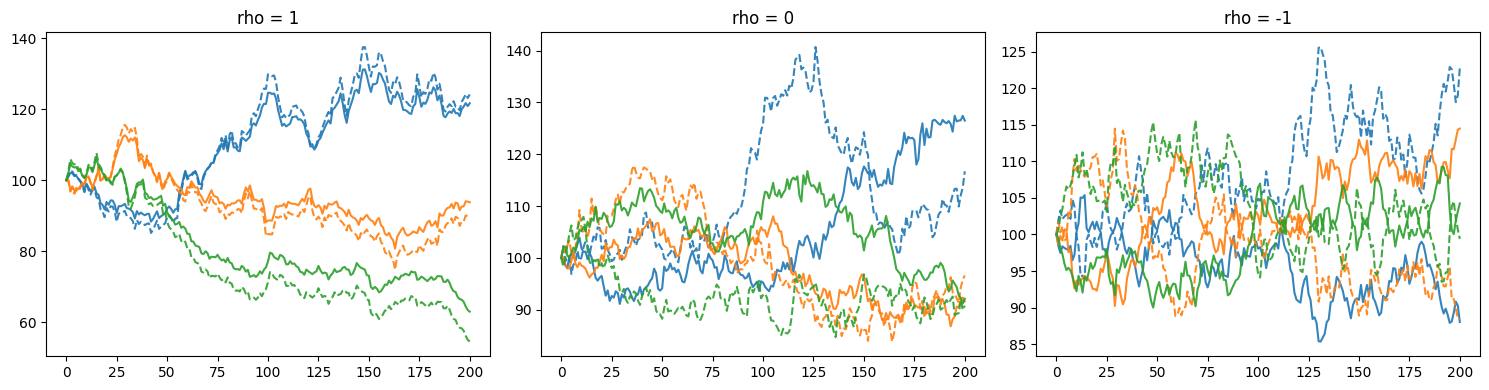

In [59]:
# show 3 paired sample paths for rho = 1, 0, -1

rhos   = [1.0, 0.0, -1.0]
titles = ["rho = 1", "rho = 0", "rho = -1"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

N_paths = 3  # number of pairs per subplot

# get the default matplotlib colour cycle
base_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for ax, rho, title in zip(axes, rhos, titles):
    S1, S2 = simulate_correlated_gbm(
        S0_1, S0_2,
        mu1, mu2,
        sigma1, sigma2,
        rho,
        T,
        N_steps,
        N_paths,
        rng,
    )

    for i in range(N_paths):
        color = base_colors[i % len(base_colors)]
        ax.plot(S1[i], color=color, alpha=0.9)              # asset 1: solid
        ax.plot(S2[i], color=color, linestyle="--", alpha=0.9)  # asset 2: dashed

    ax.set_title(title)

plt.tight_layout()
plt.savefig("figs/example_terminals.png", dpi=300, bbox_inches="tight")
plt.show()


We plot a few paired sample paths for three correlation values. When $\rho = 1$ each coloured pair moves almost identically; when $\rho = 0$ the movements are independent; when $\rho = -1$ each pair moves in opposite directions as expected.

### Analytical portfolio variance

For each asset we write the log-return over $[0,T]$ as
$$
R_i = \log\left(\frac{S_T^{(i)}}{S_0^{(i)}}\right), \qquad i = 1,2.
$$

Under the geometric Brownian motion model,
$$
\operatorname{Var}(R_i) = \sigma_i^2 T, \qquad
\operatorname{Cov}(R_1, R_2) = \rho \sigma_1 \sigma_2 T.
$$

For portfolio weights $w_1, w_2$ the portfolio log-return is
$$
R_p = w_1 R_1 + w_2 R_2.
$$

Using basic properties of covariance,
$$
\operatorname{Var}(R_p)
= w_1^2 \sigma_1^2 T
+ w_2^2 \sigma_2^2 T
+ 2 w_1 w_2 \rho \sigma_1 \sigma_2 T.
$$

This gives a closed form expression for the portfolio variance as a function of the correlation parameter $\rho$. We will now compare this formula with empirical estimates obtained from simulation.


In [52]:
def portfolio_return(S1, S2, w1, w2):
    """
    compute portfolio log-return at time T
    """
    R1 = np.log(S1[:, -1] / S1[:, 0])
    R2 = np.log(S2[:, -1] / S2[:, 0])
    return w1 * R1 + w2 * R2


In [53]:
def analytical_variance(rho, w1, w2, sigma1, sigma2, T):
    """
    portfolio log-return variance as a function of rho
    """
    return (
        w1**2 * sigma1**2 * T
        + w2**2 * sigma2**2 * T
        + 2 * w1 * w2 * rho * sigma1 * sigma2 * T
    )


## Monte Carlo variance as a function of $\rho$

We now estimate the portfolio log-return variance by simulation and compare it with the analytical expression. For a fixed set of parameters we repeat the simulation for a range of correlation values $\rho \in [-1,1]$. For each $\rho$ we generate many joint paths, compute the portfolio return on each path, and take the sample variance.

This provides a numerical view of how diversification depends on correlation. When $\rho$ decreases the random movements of the two assets offset each other more effectively, so the portfolio variance should fall. The analytical formula predicts a linear dependence on $\rho$. The goal of this section is to verify this behaviour empirically.


### Simulation procedure

For each value of $\rho$ in a chosen grid we repeat the following steps:

1. simulate $N_{\text{paths}}$ joint price paths $(S_t^{(1)}, S_t^{(2)})$ up to time $T$ using the function `simulate_correlated_gbm`,  
2. compute the portfolio log-return on each path,
   $$
   R_p = w_1 \log\!\left(\frac{S_T^{(1)}}{S_0^{(1)}}\right)
       + w_2 \log\!\left(\frac{S_T^{(2)}}{S_0^{(2)}}\right),
   $$
3. estimate the empirical variance of $R_p$ across all simulated paths,
4. evaluate the analytical variance
   $$
   \operatorname{Var}(R_p)
   = w_1^2 \sigma_1^2 T
   + w_2^2 \sigma_2^2 T
   + 2 w_1 w_2 \rho \sigma_1 \sigma_2 T,
   $$
5. store both values for comparison.

This produces a numerical estimate of the portfolio variance as a function of the correlation parameter $\rho$. We then plot the empirical and analytical variances on the same graph to assess the agreement between simulation and theory.


### Experiment

In [63]:
# grid of rho values
rho_values = np.linspace(-0.9, 0.9, 19)

empirical_var = []
analytical_var = []

for rho in rho_values:
    # simulate joint GBM paths
    S1, S2 = simulate_correlated_gbm(
        S0_1, S0_2,
        mu1, mu2,
        sigma1, sigma2,
        rho,
        T,
        N_steps,
        N_paths,
        rng
    )

    # portfolio log-returns
    Rp = portfolio_return(S1, S2, w1, w2)

    # empirical variance of the portfolio log-return
    empirical_var.append(np.var(Rp, ddof=1))

    # analytical variance
    analytical_var.append(
        analytical_variance(rho, w1, w2, sigma1, sigma2, T)
    )


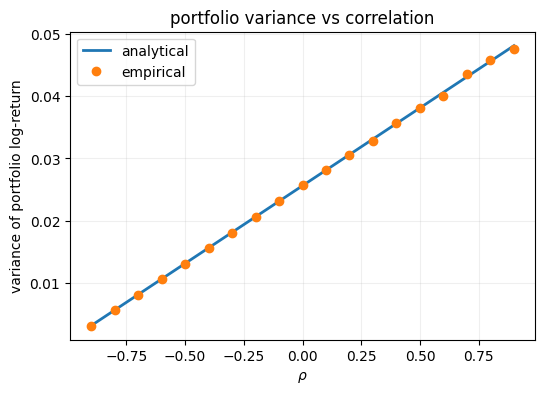

In [64]:
plt.figure(figsize=(6,4))

plt.plot(rho_values, analytical_var, linewidth=2, label="analytical")
plt.plot(rho_values, empirical_var, "o", label="empirical")

plt.xlabel(r"$\rho$")
plt.ylabel("variance of portfolio log-return")
plt.title("portfolio variance vs correlation")
plt.legend()
plt.grid(alpha=0.2)

plt.savefig("figs/portfolio_variance_vs_correlation.png", dpi=300, bbox_inches="tight")
plt.show()


### Interpretation

The empirical Monte Carlo estimates align closely with the analytical variance for all values of $\rho$. The relationship is linear, as predicted by the formula
$$
\operatorname{Var}(R_p)
= w_1^2 \sigma_1^2 T
+ w_2^2 \sigma_2^2 T
+ 2 w_1 w_2 \rho \sigma_1 \sigma_2 T.
$$
As $\rho$ increases the portfolio variance rises, reflecting weaker diversification. When $\rho$ is negative the random movements of the two assets partially offset each other, leading to lower overall risk. These results confirm the expected dependence of portfolio risk on correlation in the two-asset geometric Brownian motion setting.


## Distribution of portfolio outcomes

To visualise the effect of correlation on diversification we examine the distribution of portfolio log-returns at maturity for three values of $\rho$. For each choice of $\rho$ we simulate many independent joint paths and record the resulting portfolio returns. The mean should remain similar across all cases, since correlation does not affect the marginal behaviour of each asset. The spread of the distribution, however, reflects the portfolio risk: a higher correlation leads to larger fluctuations in the combined position, while a negative correlation reduces variability. Plotting these distributions side by side provides a direct illustration of how correlation influences the stability of the portfolio.


### Procedure

We fix all model and simulation parameters and choose three correlation levels, for example $\rho = -0.8,\ 0,\ 0.8$. For each value of $\rho$ we generate a large number of independent paths using the function `simulate_correlated_gbm`. From each path we compute the portfolio log-return
$$
R_p = w_1 \log\!\left(\frac{S_T^{(1)}}{S_0^{(1)}}\right)
    + w_2 \log\!\left(\frac{S_T^{(2)}}{S_0^{(2)}}\right).
$$
Collecting all returns produces an empirical distribution of possible portfolio outcomes at time $T$. We then form three histograms, one for each correlation value, to compare how the distribution widens or narrows as $\rho$ varies. This provides a direct view of the diversification effect implied by the two-asset model.


In [56]:
# colours for each rho
colors = {
    -0.8: "#1f77b4",   # blue
    0.0:  "#2ca02c",   # green
    0.8:  "#d62728",   # red
}

# robust global x-range for clean comparison
all_vals = np.concatenate([results[rho] for rho in rho_list])
xmin, xmax = np.percentile(all_vals, [0.2, 99.8])

# common bin structure
bins = np.linspace(xmin, xmax, 60)

# compute global y-limit
densities = []
for rho in rho_list:
    counts, _ = np.histogram(results[rho], bins=bins, density=True)
    densities.append(np.max(counts))
ymax = max(densities) * 1.15


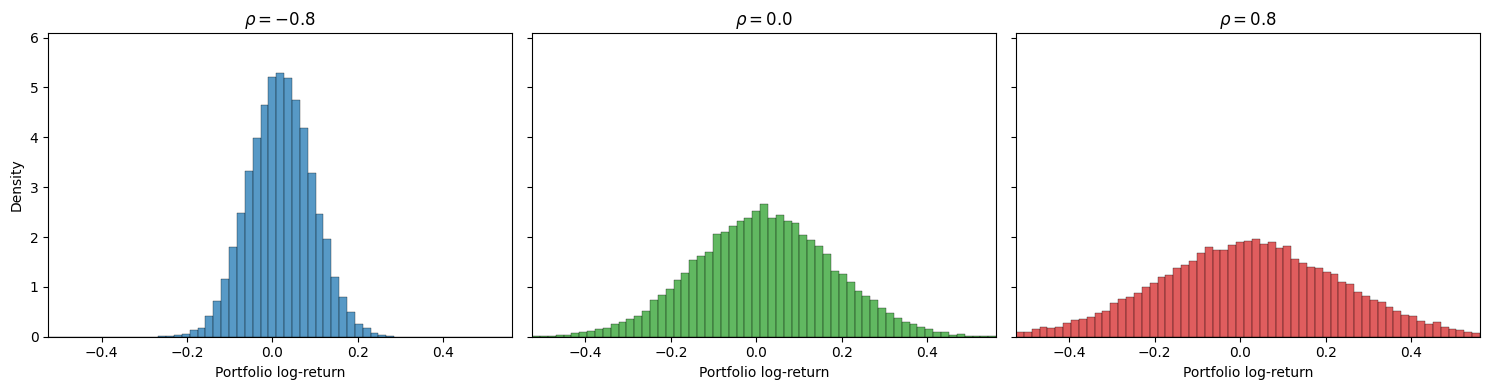

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, rho in zip(axes, rho_list):
    ax.hist(
        results[rho],
        bins=bins,
        density=True,
        alpha=0.75,
        color=colors[rho],
        edgecolor="black",
        linewidth=0.3,
    )
    ax.set_title(f"$\\rho = {rho}$", fontsize=12)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, ymax)
    ax.set_xlabel("Portfolio log-return", fontsize=10)

axes[0].set_ylabel("Density", fontsize=10)

plt.tight_layout()
plt.savefig("figs/rho_histograms.png", dpi=300, bbox_inches="tight")
plt.show()


### Kernel density estimation

To obtain a smoother view of the distribution of portfolio log-returns we use kernel density estimation (KDE). A KDE replaces the discrete histogram counts with a continuous estimate of the underlying probability density. Instead of placing all mass into fixed-width bins, the method centres a smooth kernel (typically a Gaussian) at each data point and sums these contributions. The result is a continuous curve that approximates the shape of the distribution without depending on bin choices.

KDE is particularly useful here because the differences in spread between the cases $\rho=-0.8,\ 0,\ 0.8$ become clearer when the estimated densities are plotted on the same scale. The mean of each distribution remains similar, while the width of the KDE curve reflects the effect of correlation on portfolio risk.


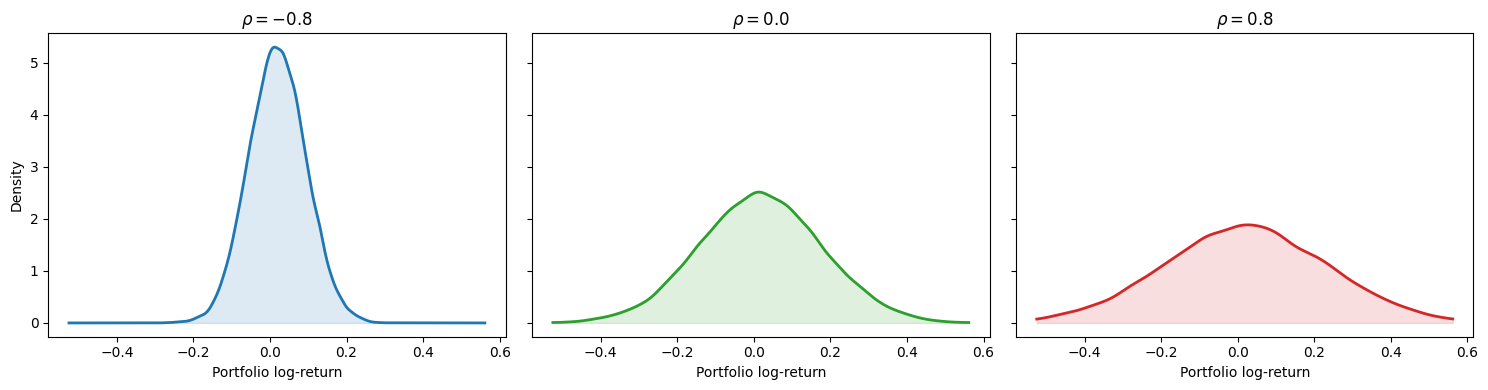

In [58]:
# colours for KDE curves
colors = {
    -0.8: "#1f77b4",   # blue
    0.0:  "#2ca02c",   # green
    0.8:  "#d62728",   # red
}

# prepare a common x-grid across all densities
all_vals = np.concatenate([results[rho] for rho in rho_list])
xmin, xmax = np.percentile(all_vals, [0.2, 99.8])
xgrid = np.linspace(xmin, xmax, 500)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, rho in zip(axes, rho_list):
    Rp = results[rho]

    # compute KDE
    kde = gaussian_kde(Rp)
    yvals = kde(xgrid)

    # plot KDE
    ax.plot(xgrid, yvals, color=colors[rho], linewidth=2)
    ax.fill_between(xgrid, yvals, color=colors[rho], alpha=0.15)

    ax.set_title(f"$\\rho = {rho}$", fontsize=12)
    ax.set_xlabel("Portfolio log-return", fontsize=10)

axes[0].set_ylabel("Density", fontsize=10)

plt.tight_layout()
plt.savefig("figs/KDE_curves.png", dpi=300, bbox_inches="tight")
plt.show()


### Interpretation

The KDE curves show the change in the spread of portfolio log-returns as the correlation parameter varies. All three densities have similar centres, since the mean behaviour of the assets is unaffected by $\rho$. The width of each curve, however, reflects the portfolio risk. For $\rho = -0.8$ the distribution is narrow, indicating strong diversification. At $\rho = 0$ the spread increases, and for $\rho = 0.8$ the distribution becomes noticeably wider. This confirms that higher correlation reduces the stabilising effect of diversification and leads to greater variability in portfolio outcomes.


## Conclusion

This project investigated how correlation affects the behaviour of a two-asset portfolio in a simple geometric Brownian motion framework. The analytical variance formula shows that the portfolio risk depends linearly on the correlation parameter, while the Monte Carlo experiments confirmed this dependence numerically. The empirical variances aligned closely with the theoretical curve, and the distributional plots illustrated the change in dispersion directly: negative correlation produced stable outcomes, zero correlation gave intermediate variability, and positive correlation led to the widest distribution of returns.

The implications of this behaviour extend beyond the toy setting of the model. Correlation plays a central role in portfolio construction, risk management, and stress testing. Diversification relies on combining assets whose risks do not move in lockstep, and the results here quantify that principle in its simplest form. In practice, estimating and monitoring correlations is a key part of managing exposure, designing hedges, and understanding how a portfolio may react to market conditions. Even in more complex models, the intuition remains the same: lower correlation reduces joint variability.

Several natural extensions follow from this work. One can study portfolios with more than two assets, explore time-varying or stochastic correlations, or replace geometric Brownian motion with models that capture jumps or heavier tails. Another direction is to analyse the impact of correlation on risk measures beyond variance, such as Value-at-Risk or Expected Shortfall, or to investigate how estimation error in sample correlations propagates through portfolio construction. These extensions provide more realistic settings, but the basic message remains: correlation is a fundamental driver of portfolio risk, and simulation is an effective tool for understanding its behaviour.
